In [12]:
#authors:
#Shiva Ganga
#Tharunn Golthi
#Abhinaya
#Susmitha
#importing libraries numpy,pandas,mathplotlib for extracting, modifying and visualizing the data

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from subprocess import check_output

# Any results you write to the current directory are saved as output.

test.csv
train.csv



In [13]:
#loading input train file to train
train = pd.read_csv("/train.csv")
#loading iput test file to test
test = pd.read_csv("/test.csv")
#printing the top
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


This is how the training data is given. 

In [14]:
test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


The test data only contains questions but not their id's as in train data, as you can see above. 

In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404290 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


The training data has 404290 instances. 

In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345796 entries, 0 to 2345795
Data columns (total 3 columns):
test_id      int64
question1    object
question2    object
dtypes: int64(1), object(2)
memory usage: 53.7+ MB


The test data has 2345796 instances.

In [17]:
train_duplicate_mean = train['is_duplicate'].mean()
print ("mean of train data is_duplicate column",train_duplicate_mean)

mean of train data is_duplicate column 0.369197853026293


By finding the mean on the is_duplicate field of train data, we see that about 37% of the train data have pair of questions, which are labeled is_duplicate as 1. 

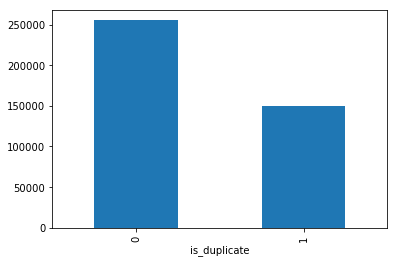

In [18]:
pt = train.groupby('is_duplicate')['id'].count()
pt.plot.bar()

The plot shows the is_duplicate distribution in the train data. 

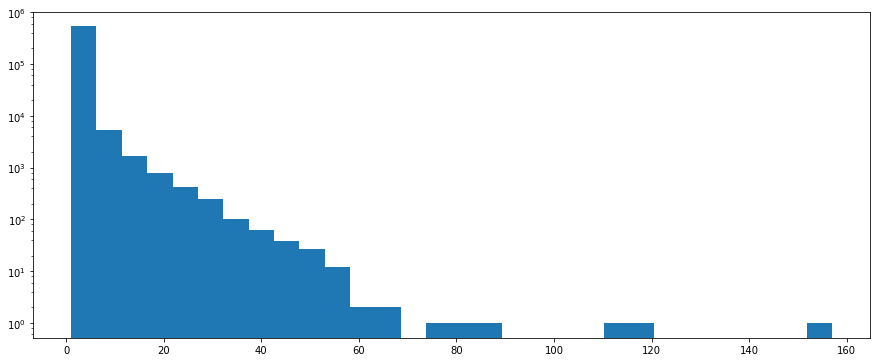

In [19]:
# plotting data for number of questions vs number of occurences of the question 
question_id_1 = train['qid1'].tolist()
question_id_2 = train['qid2'].tolist()

question_id = pd.Series(question_id_1+question_id_2)
plt.figure(figsize=(15,6))
plt.hist(question_id.value_counts(), bins= 30)
plt.yscale('log', nonposy='clip')

By plotting the no. of questions vs no. of occurences of the question, we observe that most of the questions only appear a few times, except very few. 

In [20]:
#using nltk corpus for stopwords
from nltk.corpus import stopwords as st
#stopwords
stopwords_set = set(st.words("english"))

#returns total words in a sentence
def word_dict(sentence):
    question_words_dict = {}
    for word in sentence.lower().split():
        if word not in stopwords_set:
            question_words_dict[word] = 1
    return question_words_dict
#calculating feature common_word_percentage for each row
def common_words_percentage(entry):
    question_1_words = word_dict(str(entry['question1']))
    question_2_words = word_dict(str(entry['question2']))
     
    if len(question_1_words) == 0 or len(question_2_words) == 0:
        return 0
    shared_in_q1 = [word for word in question_1_words.keys() if word in question_2_words]
    feature_Ratio = ( 2*len(shared_in_q1) )/(len(question_1_words)+len(question_2_words))
    return feature_Ratio

In [21]:
#calculating tfidf weights 
def tfidf_weights(entry):
    question_1_words = word_dict(str(entry['question1']))
    question_2_words = word_dict(str(entry['question2']))
    if len(question_1_words) == 0 or len(question_2_words) == 0:
        return 0
    
    common_wts_1 = [weights.get(w, 0) for w in question_1_words.keys() if w in question_2_words]  
    common_wts_2 = [weights.get(w, 0) for w in question_2_words.keys() if w in question_2_words]
    common_wts = common_wts_1 + common_wts_2
    whole_wts = [weights.get(w, 0) for w in question_1_words] + [weights.get(w, 0) for w in question_2_words]
    
    feature_tfidf = np.sum(common_wts) / np.sum(whole_wts)
    return feature_tfidf

In [22]:

list_of_questions = (train['question1'].str.lower().astype('U').tolist() + train['question2'].str.lower().astype('U').tolist())
#calcutaing Tfifs feature using inbuilt libraries
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df = 50,max_features = 3000000,ngram_range = (1,10))
X = vectorizer.fit_transform(list_of_questions)
idf = vectorizer.idf_
weights = (dict(zip(vectorizer.get_feature_names(), idf)))

In [23]:
#feature train data frame
X_TrainData = pd.DataFrame()
#feature test data frame
X_TestData = pd.DataFrame()
# adding common_word_percent feature to train data
X_TrainData['common_word_percent'] = train.apply(common_words_percentage, axis=1, raw=True)
# adding feature_ifidf feature to train data
X_TrainData['feature_ifidf'] = train.apply(tfidf_weights, axis = 1, raw = True)
Y_TrainData = train['is_duplicate'].values
# adding common_word_percent feature to test data
X_TestData['common_word_percent'] = test.apply(common_words_percentage, axis = 1, raw = True)
# adding feature_ifidf feature to test data
X_TestData['feature_ifidf'] = test.apply(tfidf_weights, axis = 1, raw = True)

/opt/conda/bin/ipython:12: RuntimeWarning: invalid value encountered in long_scalars


In [24]:
# calculating jacardian similarity
import nltk
def jaccard_similarity_coefficient(row):
    if (type(row['question1']) is str) and (type(row['question2']) is str):
        words_1 = row['question1'].lower().split()
        words_2 = row['question2'].lower().split()
    else:
        #tokeninzing using nltk
        words_1 = nltk.word_tokenize(str(row['question1']))
        words_2 = nltk.word_tokenize(str(row['question2']))
   
    joint_words = set(words_1).union(set(words_2))
    intersection_words = set(words_1).intersection(set(words_2))
    return len(intersection_words)/len(joint_words)

In [25]:
# removing NA values in tarainig data
train = train.fillna("")

In [26]:
# adding jaccard distance feature to train and test data 
X_TrainData['Jacard_Distance'] = train.apply(jaccard_similarity_coefficient, axis = 1, raw = True)
X_TestData['Jacard_Distance'] = test.apply(jaccard_similarity_coefficient, axis = 1, raw = True)

In [27]:

from sklearn.metrics.pairwise import cosine_similarity as cs
import re, math
from collections import Counter

WORD = re.compile(r'\w+')
# calculating the cosine similarity between two vectors
def _cosine_similarity(vector_1, vector_2):
    
    common_keys = set(vector_1.keys()) & set(vector_2.keys())
    array1 = [vector_1[x]**2 for x in vector_1.keys()]
    array2 = [vector_2[x]**2 for x in vector_2.keys()]
    
    if not (math.sqrt(sum(array1)) * math.sqrt(sum(array2))):
        return 0.0
    else:
        return (float(sum([vector_1[x] * vector_2[x] for x in common_keys]))) / (math.sqrt(sum(array1)) * math.sqrt(sum(array2)))
# making sentence to vector format
def sentence_transform(sentence):
     words = WORD.findall(sentence)
     return Counter(words)
#method used to find cosine similarity for each row of data frame
def cosine_sim(row):
    vector1 = sentence_transform(str(row['question1']))
    vector2 = sentence_transform(str(row['question2']))
    sim = _cosine_similarity(vector1,vector2)
    return sim

X_TrainData['cosine_sim'] = train.apply(cosine_sim,axis = 1,raw = True )
X_TestData['cosine_sim'] = test.apply(cosine_sim,axis = 1,raw = True )

In [11]:
import csv, math, random , sys, random
from nltk.corpus import wordnet as wn
from nltk.corpus import brown
import math
import nltk
import sys
from nltk.corpus import stopwords
import numpy as np
import re
from pandas import read_csv
from nltk.corpus import wordnet as wn
from nltk.corpus import brown
import math
import nltk
import sys



##################
ALPHA = 0.2
BETA = 0.45
ETA = 0.4
PHI = 0.2
DELTA = 0.85

brown_freqs = dict()
N = 0


######################### word similarity ##########################
def get_best_synset_pair(word_1, word_2):
    """ 
    Choose the pair with highest path similarity among all pairs. 
    Mimics pattern-seeking behavior of humans.
    """
    max_sim = -1.0
    synsets_1 = wn.synsets(word_1)
    synsets_2 = wn.synsets(word_2)
    if len(synsets_1) == 0 or len(synsets_2) == 0:
        return None, None
    else:
        max_sim = -1.0
        best_pair = None, None
        for synset_1 in synsets_1:
            for synset_2 in synsets_2:
                sim = wn.path_similarity(synset_1, synset_2)
                if sim != None and sim > max_sim:
                    max_sim = sim
                    best_pair = synset_1, synset_2
        return best_pair


def length_dist(synset_1, synset_2):
    """
    Return a measure of the length of the shortest path in the semantic 
    ontology (Wordnet in our case as well as the paper's) between two 
    synsets.
    """
    l_dist = sys.maxsize
    if synset_1 is None or synset_2 is None:
        return 0.0
    if synset_1 == synset_2:
        # if synset_1 and synset_2 are the same synset return 0
        l_dist = 0.0
    else:
        wset_1 = set([str(x.name()) for x in synset_1.lemmas()])
        wset_2 = set([str(x.name()) for x in synset_2.lemmas()])
        if len(wset_1.intersection(wset_2)) > 0:
            # if synset_1 != synset_2 but there is word overlap, return 1.0
            l_dist = 1.0
        else:
            # just compute the shortest path between the two
            l_dist = synset_1.shortest_path_distance(synset_2)
            if l_dist is None:
                l_dist = 0.0
    # normalize path length to the range [0,1]
    return math.exp(-ALPHA * l_dist)


def hierarchy_dist(synset_1, synset_2):
    """
    Return a measure of depth in the ontology to model the fact that 
    nodes closer to the root are broader and have less semantic similarity
    than nodes further away from the root.
    """
    h_dist = sys.maxsize
    if synset_1 is None or synset_2 is None:
        return h_dist
    if synset_1 == synset_2:
        # return the depth of one of synset_1 or synset_2
        h_dist = max([x[1] for x in synset_1.hypernym_distances()])
    else:
        # find the max depth of least common subsumer
        hypernyms_1 = {x[0]: x[1] for x in synset_1.hypernym_distances()}
        hypernyms_2 = {x[0]: x[1] for x in synset_2.hypernym_distances()}
        lcs_candidates = set(hypernyms_1.keys()).intersection(
            set(hypernyms_2.keys()))
        if len(lcs_candidates) > 0:
            lcs_dists = []
            for lcs_candidate in lcs_candidates:
                lcs_d1 = 0
                if lcs_candidate in hypernyms_1:
                    lcs_d1 = hypernyms_1[lcs_candidate]
                lcs_d2 = 0
                if lcs_candidate in hypernyms_2:
                    lcs_d2 = hypernyms_2[lcs_candidate]
                lcs_dists.append(max([lcs_d1, lcs_d2]))
            h_dist = max(lcs_dists)
        else:
            h_dist = 0
    return ((math.exp(BETA * h_dist) - math.exp(-BETA * h_dist)) /
            (math.exp(BETA * h_dist) + math.exp(-BETA * h_dist)))


def word_similarity(word_1, word_2):
    synset_pair = get_best_synset_pair(word_1, word_2)
    return (length_dist(synset_pair[0], synset_pair[1]) *
            hierarchy_dist(synset_pair[0], synset_pair[1]))


######################### sentence similarity ##########################

def most_similar_word(word, word_set):
    """
    Find the word in the joint word set that is most similar to the word
    passed in. We use the algorithm above to compute word similarity between
    the word and each word in the joint word set, and return the most similar
    word and the actual similarity value.
    """
    max_sim = -1.0
    sim_word = ""
    for ref_word in word_set:
        sim = word_similarity(word, ref_word)
        if sim > max_sim:
            max_sim = sim
            sim_word = ref_word
    return sim_word, max_sim


def info_content(lookup_word):
    """
    Uses the Brown corpus available in NLTK to calculate a Laplace
    smoothed frequency distribution of words, then uses this information
    to compute the information content of the lookup_word.
    """
    global N
    if N == 0:
        # poor man's lazy evaluation
        for sent in brown.sents():
            for word in sent:
                word = word.lower()
                if word not in brown_freqs:
                    brown_freqs[word] = 0
                brown_freqs[word] = brown_freqs[word] + 1
                N = N + 1
    lookup_word = lookup_word.lower()
    n = 0 if lookup_word not in brown_freqs else brown_freqs[lookup_word]
    return 1.0 - (math.log(n + 1) / math.log(N + 1))


def semantic_vector(words, joint_words, info_content_norm):
    """
    Computes the semantic vector of a sentence. The sentence is passed in as
    a collection of words. The size of the semantic vector is the same as the
    size of the joint word set. The elements are 1 if a word in the sentence
    already exists in the joint word set, or the similarity of the word to the
    most similar word in the joint word set if it doesn't. Both values are 
    further normalized by the word's (and similar word's) information content
    if info_content_norm is True.
    """
    sent_set = set(words)
    semvec = np.zeros(len(joint_words))
    i = 0
    for joint_word in joint_words:
        if joint_word in sent_set:
            # if word in union exists in the sentence, s(i) = 1 (unnormalized)
            semvec[i] = 1.0
            if info_content_norm:
                semvec[i] = semvec[i] * math.pow(info_content(joint_word), 2)
        else:
            # find the most similar word in the joint set and set the sim value
            sim_word, max_sim = most_similar_word(joint_word, sent_set)
            semvec[i] = PHI if max_sim > PHI else 0.0
            if info_content_norm:
                semvec[i] = semvec[i] * info_content(joint_word) * info_content(sim_word)
        i = i + 1
    return semvec


def semantic_similarity(row):
    """
    Computes the semantic similarity between two sentences as the cosine
    similarity between the semantic vectors computed for each sentence.
    """
    info_content_norm = True
    sentence_1 = row['question1']
    sentence_2 = row['question2']
    
    words_1 = nltk.word_tokenize(sentence_1)
    words_2 = nltk.word_tokenize(sentence_2)
    joint_words = set(words_1).union(set(words_2))
    vec_1 = semantic_vector(words_1, joint_words, info_content_norm)
    vec_2 = semantic_vector(words_2, joint_words, info_content_norm)
    return np.dot(vec_1, vec_2.T) / (np.linalg.norm(vec_1) * np.linalg.norm(vec_2))



In [28]:
#if we implement semantic similarity it will take hours and hours of processing time 
#so we are not including the follwing feature 
# we have included the whole results and description of this feature in the report
"""X_TrainData['semantic_sim'] = train.apply(semantic_similarity,axis = 1,raw = True )
X_TestData['semantic_sim'] = test.apply(semantic_similarity,axis = 1,raw = True )"""
X_TrainData

,common_word_percent,feature_ifidf,Jacard_Distance,cosine_sim
0,0.727273,0.903160,0.769231,0.944911
1,0.307692,0.817249,0.250000,0.536875
2,0.363636,0.685127,0.200000,0.253546
3,0.000000,0.594645,0.000000,0.000000
4,0.000000,0.497811,0.111111,0.419314
5,0.470588,0.683637,0.347826,0.556415
6,0.000000,0.865550,0.000000,0.000000
7,0.500000,0.598609,0.333333,0.503953
8,0.500000,1.000000,0.600000,0.801784
9,0.363636,0.792924,0.200000,0.444444


In [29]:
from sklearn.cross_validation import train_test_split
# train test split validation data 20% and test data 80%
X_TrainData, X_ValidData, Y_TrainData, Y_ValidData = train_test_split(X_TrainData, Y_TrainData, test_size=0.20, random_state=4242)

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [30]:
import xgboost as xgb

xg_TrainData = xgb.DMatrix(X_TrainData, label=Y_TrainData)
xg_ValidData = xgb.DMatrix(X_ValidData, label=Y_ValidData)

watchlist = [(xg_TrainData, 'train'), (xg_ValidData, 'valid')]
#training using XGBoost using evalustion metric as logloss
bst = xgb.train({'objective':'binary:logistic','eval_metric':'logloss','eta':0.02,'max_depth' :5}, xg_TrainData, 500, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.68579	valid-logloss:0.685881
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.625659	valid-logloss:0.626515
[20]	train-logloss:0.583104	valid-logloss:0.584558
[30]	train-logloss:0.551923	valid-logloss:0.553839
[40]	train-logloss:0.528532	valid-logloss:0.530831
[50]	train-logloss:0.510636	valid-logloss:0.513263
[60]	train-logloss:0.496685	valid-logloss:0.499593
[70]	train-logloss:0.485819	valid-logloss:0.48896
[80]	train-logloss:0.477329	valid-logloss:0.480679
[90]	train-logloss:0.470713	valid-logloss:0.474249
[100]	train-logloss:0.46549	valid-logloss:0.469183
[110]	train-logloss:0.461127	valid-logloss:0.464952
[120]	train-logloss:0.457808	valid-logloss:0.461726
[130]	train-logloss:0.455032	valid-logloss:0.45903
[140]	train-logloss:0.452821	valid-logloss:0.456909
[150]	train-logloss:0.450989	valid-logloss:0.455159
[160]	train-logloss:0.449442	val

In [31]:
X_TestData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345796 entries, 0 to 2345795
Data columns (total 4 columns):
common_word_percent    float64
feature_ifidf          float64
Jacard_Distance        float64
cosine_sim             float64
dtypes: float64(4)
memory usage: 71.6 MB


In [32]:

xg_TestData = xgb.DMatrix(X_TestData)
xg_ValidData = xgb.DMatrix(X_ValidData)
#predited values using XG boost
Predict_TestData = bst.predict(xg_TestData)
Predict_ValidData = bst.predict(xg_ValidData)



0.83383000979999999

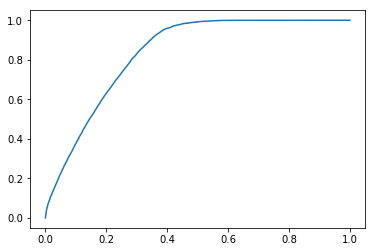

In [37]:
#Roc metric
from sklearn.metrics import precision_recall_curve, auc, roc_curve
fpr, tpr, _ = roc_curve(Y_ValidData, Predict_ValidData)
roc_area = auc(fpr, tpr)
plt.plot(fpr, tpr)
np.round(roc_area, 10)

0.68226238861134547

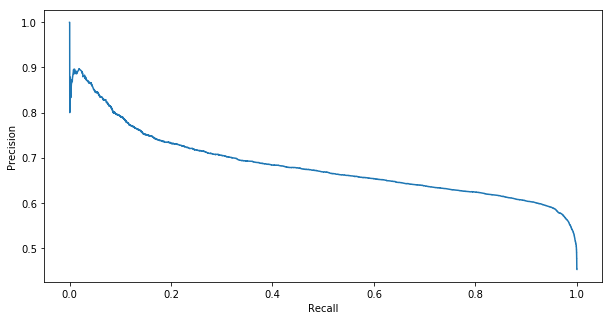

In [35]:
# precision Recall curve
precison, recall, _ = precision_recall_curve(Y_ValidData, Predict_ValidData)
plt.figure(figsize=(10,5))

plt.plot(recall, precison)
plt.xlabel('Recall')
plt.ylabel('Precision')
auc(recall, precison)

In [36]:
#final classes to result.csv
result = pd.DataFrame()
result['test_id'] = test['test_id']
result['is_duplicate'] = Predict_TestData
result.to_csv('result.csv', index=False)